In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from models.vanilla import VanillaModel
from utils.utils import create_data_loaders, freq_to_image
from ext.training import ReconstructionTrainer
from ext.plot import plot_fit

%load_ext autoreload
%autoreload 2

In [5]:
from argparse import Namespace
args = {
    "seed" : 0,
    "data_path" : '/storage/downloads/fastmri_knee/',
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "batch_size" : 16,
    "num_workers" : 1,
    "num_epochs" : 10,
    "report_interval" : 1,
    "drop_rate" : .8,
    "learn_mask" : False,
    "results_root" : 'results',
    "lr" : 1e-2,
    "mask_lr" : 1e-2,
    "val_test_split" : .3,
}

args = Namespace(**args)

In [6]:

train_loader, validation_loader, test_loader = create_data_loaders(args) #get dataloaders

In [ ]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print(len(validation_loader.dataset))
for i in range(5):
    x, y = train_loader.dataset[i]
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(x[:,:,0].numpy(), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(x[:,:,1].numpy(), cmap='gray')

In [ ]:
from utils.utils import freq_to_image
res = freq_to_image(x.unsqueeze(0))
plt.subplot(1, 3, 1)
plt.imshow(res[0])
plt.subplot(1, 3, 2)
plt.imshow(y)
plt.subplot(1, 3, 3)
plt.imshow(y - res[0])

In [ ]:
def inverse_fft2_shift(kspace):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace, axes=(-2,-1)), norm='ortho'),axes=(-2,-1))

In [ ]:
import h5py

hf = h5py.File("/storage/downloads/fastmri_knee/singlecoil_train/file1002518.h5")

volume_kspace = hf['kspace'][()]
reconstruction = hf['reconstruction_esc'][()]
print(volume_kspace.shape)  # dimensions: (number of slices, number of coils, height, width

# middle_index = volume_kspace.shape[0] //2
# slice_kspace = volume_kspace[middle_index] # Choosing the middle slice of this volume

def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

show_coils(np.log(np.abs(volume_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10
# Note that a small constant is added for numerical stability.
show_coils(np.abs(inverse_fft2_shift(volume_kspace)), [0, 5, 10])  # This shows coils 0, 5 and 10
show_coils(reconstruction, [0, 5, 10])  # This shows coils 0, 5 and 10
# show diff between reconstruction and volume_kspace
from data.transforms import complex_center_crop
inverse = inverse_fft2_shift(volume_kspace)
print(inverse.shape)
# Extract real and imaginary parts
real_part = torch.tensor(inverse.real)
imaginary_part = torch.tensor(inverse.imag)

# Stack real and imaginary parts along the last dimension
inverse = torch.stack((real_part, imaginary_part), dim=-1)

cropped = complex_center_crop(inverse, (320, 320))
cropped = torch.view_as_complex(cropped)
show_coils(torch.tensor(reconstruction) - np.abs(cropped), [0, 5, 10])
# print sum of diff
print(torch.sum(torch.abs(torch.tensor(reconstruction) - np.abs(cropped))))


In [ ]:
from data import transforms
resolution = 320
def transform(kspace, target):
        print(kspace.shape)
        print(kspace[100][100])
        kspace = transforms.to_tensor(kspace)
        print(kspace.shape)
        print(kspace[100][100])
        image = transforms.ifft2_regular(kspace)
        print(image.shape)
        image = transforms.complex_center_crop(image, (resolution, resolution))
        print(image.shape)
        
        image, mean, std = transforms.normalize_instance(image, eps=1e-11)
        
        normalized_kspace = transforms.fft2(image)
 
        

        target = transforms.to_tensor(target)
        target, mean, std = transforms.normalize_instance(target, eps=1e-11)

        return normalized_kspace, target


In [ ]:
transform(volume_kspace[0], volume_kspace[0])

In [ ]:
from models.subsampling import SubsamplingLayer

subsample = SubsamplingLayer(0.8, args.device, args.learn_mask) #initialize subsampling layer - use this in your own model
x, _ = train_loader.dataset[420]
img_orig = freq_to_image(x.unsqueeze(0))
new_x = subsample(x.unsqueeze(0))[0]
fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(img_orig[0])
plt.subplot(1,3,2)
plt.imshow(new_x[0])
plt.subplot(1,3,3)
diff = img_orig[0] - new_x[0]
plt.imshow(diff)
# print if there's any difference
print(torch.sum(diff))


In [ ]:
x, y = train_loader.dataset[420]
complex = torch.view_as_complex(x)
our_img = np.abs(inverse_fft2_shift(complex.numpy()))
# plot y and our_img and diff
fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(y)
plt.subplot(1,3,2)
plt.imshow(our_img)
plt.subplot(1,3,3)
plt.imshow(y - our_img)


In [ ]:
print(args.device)
print(torch.cuda.is_available())

In [ ]:
train_loader, validation_loader, test_loader = create_data_loaders(args) #get dataloaders


args.num_epochs = 50
model = VanillaModel(args.drop_rate, args.device, args.learn_mask).to(args.device) #Example instatiation - replace with your model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr) #initialize optimizer
loss_fn = torch.nn.MSELoss() #initialize loss function
trainer = ReconstructionTrainer(model, loss_fn, optimizer, args.device) #initialize trainer
fit_res = trainer.fit(train_loader, test_loader, num_epochs=args.num_epochs, print_every=args.report_interval, verbose=True)
plot_fit(fit_res)


In [ ]:
import pickle
with open('/storage/model_50.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('/storage/fit_res_50.pkl', 'wb') as f:
    pickle.dump(fit_res, f)

In [3]:
import pickle
with open('/storage/model_50.pkl', 'rb') as f:
    model = pickle.load(f)

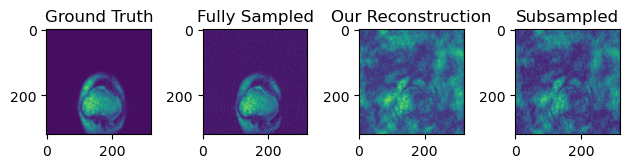

In [24]:
from utils.utils import plot_results
x, y = test_loader.dataset[0]
model.reconstruct = model.conv
plot_results(model, x, y)

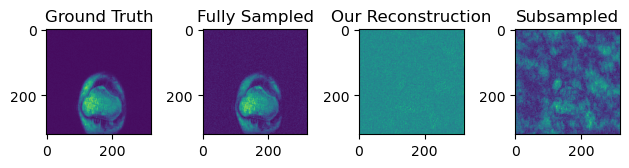

In [28]:
from utils.utils import plot_results
from models.unet_rec import UNet_Rec
x, y = test_loader.dataset[0]
model = UNet_Rec(args.drop_rate, args.device, args.learn_mask)
plot_results(model, x, y)

In [ ]:
train_loader, validation_loader, test_loader = create_data_loaders(args) #get dataloaders


args.num_epochs = 2
model = UNet_Rec(0.3, args.device, args.learn_mask).to(args.device) #Example instatiation - replace with your model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr) #initialize optimizer
loss_fn = torch.nn.MSELoss() #initialize loss function
trainer = ReconstructionTrainer(model, loss_fn, optimizer, args.device) #initialize trainer
fit_res = trainer.fit(train_loader, test_loader, num_epochs=args.num_epochs, print_every=args.report_interval, verbose=True)
plot_fit(fit_res)
